# **Importing Necessary Libraries, Data loading and Preprocessing**

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset


# Data Loading and Pre-processing
# Load the CSV file into selected_df DataFrame
selected_df = pd.read_csv('/content/processed.csv')

# Selecting features and target variable for the model
features = selected_df[['Latitude', 'Longitude', 'Glacier Form', 'Mean Elevation', 'Minimum Elevation',
                 'Maximum Elevation', 'Average_temp', 'Mean Width', 'Mean Length', 'Maximum Length',
                 'Topographic Map Year']]

# Index for 'Mean Elevation' in the feature tensor
#elevation_index = features.index('Mean Elevation')  # This should output 3, not 2 as previously mentioned

# Index for 'Mean Elevation' in the feature tensor
elevation_index = features.columns.get_loc('Mean Elevation')  # This will correctly output the index


target = selected_df['Glacier Area']  # Assuming the goal is to predict the Average Temperature

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Normalizing the features, Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Assuming the model is trained, now proceed with visualization
mean_features = scaler.mean_
std_features = scaler.scale_

# Converting to PyTorch tensors
train_targets = torch.tensor(y_train.values, dtype=torch.float32)
test_targets = torch.tensor(y_test.values, dtype=torch.float32)

# Converting to PyTorch tensors and enabling gradient computation on features
train_features = torch.tensor(X_train_scaled, dtype=torch.float32, requires_grad=True)  # Enable requires_grad
test_features = torch.tensor(X_test_scaled, dtype=torch.float32, requires_grad=True)    # Enable requires_grad

# Creating datasets and dataloaders with the new feature tensors
train_dataset = TensorDataset(train_features, train_targets)
test_dataset = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# **Model Definition and Physics-Informed Loss Function**


In [ ]:
# Define a neural network class for the Glacier Model with two linear layers and ReLU activation
import torch
from torch import nn
from torch.autograd import grad
from torch.utils.data import DataLoader, TensorDataset


# Define the GlacierModel class
class GlacierModel(nn.Module):
    def __init__(self):
        super(GlacierModel, self).__init__()
        self.linear1 = nn.Linear(11, 128)  # 11 input features
        self.relu = nn.ReLU() #ReLU activation function
        self.linear2 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 1) # Output layer with 64 inputs and 1 output

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.output(x)
        return x

## Define the physics-informed loss function, which combines traditional MSE loss with additional terms for physical consistency
# Equation without Q and u
def physics_informed_loss(outputs, features, labels, criterion, rho, c_p, k, Q, elevation_index):
    prediction_loss = criterion(outputs, labels.unsqueeze(1))

    T_x = grad(outputs.sum(), features, create_graph=True)[0][:, elevation_index] # Gradient w.r.t. mean elevation
    T_xx = grad(T_x.sum(), features, create_graph=True)[0][:, elevation_index] # Second derivative w.r.t. mean elevation
    diffusion = k * T_xx # Diffusion term using thermal conductivity
    heat_eq_residual = (rho * c_p * (- diffusion - Q)) ** 2 # Residual of the heat equation
    heat_eq_loss = torch.mean(heat_eq_residual)

    dirichlet_loss = dirichlet_boundary_condition(outputs, features, torch.tensor(0.0), elevation_index)
    neumann_loss = neumann_boundary_condition(outputs, features, elevation_index)

    # Adjust coefficients if necessary
    combined_loss = prediction_loss + 0.001 * heat_eq_loss + 0.001 * dirichlet_loss + 0.001 * neumann_loss # Combine losses with a scaling factor
    return combined_loss

#Equation with Q and u as constants
"""def physics_informed_loss(outputs, features, labels, criterion, rho, c_p, k, Q, u, elevation_index):
    prediction_loss = criterion(outputs, labels.unsqueeze(1))

    # Compute the gradients
    T_x = grad(outputs.sum(), features, create_graph=True)[0][:, elevation_index]
    T_xx = grad(T_x.sum(), features, create_graph=True)[0][:, elevation_index]

    # Compute the terms of the heat equation
    diffusion = k * T_xx
    advection = u * T_x  # Advection term (u is the ice flow velocity)
    heat_source_sink = Q  # Heat source/sink term

    # Compute the residual of the heat equation
    heat_eq_residual = (rho * c_p * (diffusion - advection - heat_source_sink)) ** 2
    heat_eq_loss = torch.mean(heat_eq_residual)

    dirichlet_loss = dirichlet_boundary_condition(outputs, features, torch.tensor(0.0), elevation_index)
    neumann_loss = neumann_boundary_condition(outputs, features, elevation_index)

    # Adjust coefficients if necessary
    combined_loss = prediction_loss + 0.001 * heat_eq_loss + 0.001 * dirichlet_loss + 0.001 * neumann_loss
    return combined_loss """


# **Defining Boundary Conditions**

In [ ]:
# Define the Dirichlet boundary condition function
def dirichlet_boundary_condition(outputs, features, expected_value, elevation_index):
    max_elevation_mask = features[:, elevation_index] == features[:, elevation_index].max()
    boundary_loss = torch.mean((outputs[max_elevation_mask] - expected_value) ** 2)
    return boundary_loss

# Define the Neumann boundary condition function
def neumann_boundary_condition(outputs, features, elevation_index):
    max_elevation_mask = features[:, elevation_index] == features[:, elevation_index].max()
    T_x = grad(outputs.sum(), features, create_graph=True)[0][max_elevation_mask, elevation_index]
    boundary_loss = torch.mean(T_x ** 2)  # Expecting zero gradient
    return boundary_loss

# **Constants for the model and training parameters**

In [ ]:
# Constants for the model
rho = 917  # Density of ice in kg/m^3
c_p = 2100  # Specific heat capacity in J/(kg·K)
k = 2.1  # Thermal conductivity in W/(m·K)
Q = 0  # Simplified as no external heat sources/sinks
elevation_index = 3 # Index for 'Mean Elevation' in feature tensor

# **Model initialization and Optimizer setup**

In [ ]:
# Model initialization, criterion, optimizer
model = GlacierModel()
criterion = nn.MSELoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

# **Training function**

In [ ]:
# Training function that integrates physics-informed loss into the training process
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, rho, c_p, k, Q, elevation_index):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs): # Loop through epochs
        # Training phase
        model.train()
        total_train_loss = 0
        for inputs, labels in train_loader:  # Training phase
            inputs.requires_grad_(True)  # Ensure gradient tracking is enabled
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = physics_informed_loss(outputs, inputs, labels, criterion, rho, c_p, k, Q, elevation_index)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * inputs.size(0)
        avg_train_loss = total_train_loss / len(train_loader.dataset)  # Calculate average training loss
        train_losses.append(avg_train_loss)

        # Validation phase
        total_val_loss = 0
        for inputs, labels in test_loader:
            inputs.requires_grad_(True)  # Ensure gradient tracking is enabled even in validation
            outputs = model(inputs)
            loss = physics_informed_loss(outputs, inputs, labels, criterion, rho, c_p, k, Q, elevation_index)
            total_val_loss += loss.item() * inputs.size(0)
        avg_val_loss = total_val_loss / len(test_loader.dataset)
        val_losses.append(avg_val_loss)

         # Print training progress
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}')

    return train_losses, val_losses



# Execute the training loop for 1000 epochs
train_losses, val_losses = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=1000, rho=rho, c_p=c_p, k=k, Q=Q, elevation_index=elevation_index)


Epoch 1/1000, Training Loss: 64.82593135442755, Validation Loss: 34.18346548050831
Epoch 2/1000, Training Loss: 25.954122272723616, Validation Loss: 24.989445587727257
Epoch 3/1000, Training Loss: 18.458071607712416, Validation Loss: 19.75344349893483
Epoch 4/1000, Training Loss: 16.467214118611444, Validation Loss: 18.886550043106315
Epoch 5/1000, Training Loss: 14.650995985771548, Validation Loss: 16.18848190241283
Epoch 6/1000, Training Loss: 13.968258096025435, Validation Loss: 15.328055613530436
Epoch 7/1000, Training Loss: 13.015124722743773, Validation Loss: 17.484240298596337
Epoch 8/1000, Training Loss: 13.448798775664583, Validation Loss: 15.717852646838715
Epoch 9/1000, Training Loss: 12.659810454878402, Validation Loss: 15.806472457161513
Epoch 10/1000, Training Loss: 13.025297308279647, Validation Loss: 14.04583138888585
Epoch 11/1000, Training Loss: 12.195417163144601, Validation Loss: 20.288748246899985
Epoch 12/1000, Training Loss: 12.64001609733955, Validation Loss: 13

# **Loss Visualization**

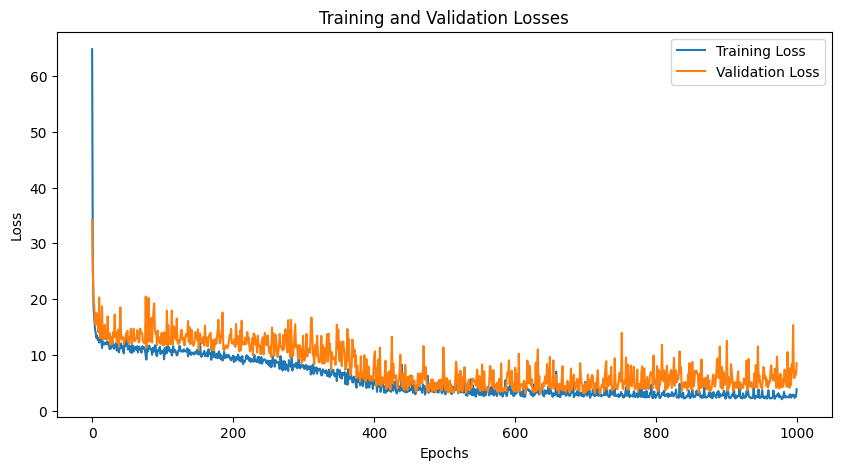

In [ ]:
# Plot the training and validation losses over epochs
import matplotlib.pyplot as plt

# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# **Advanced Visualization of Model Predictions**

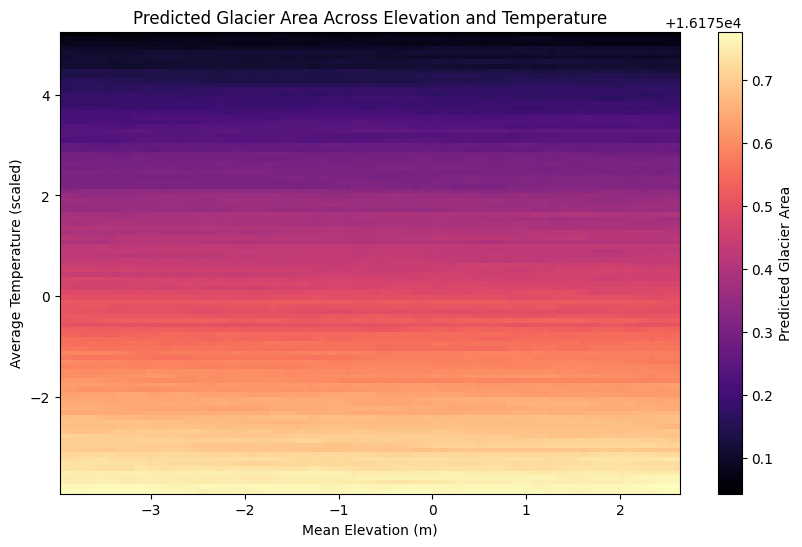

In [ ]:
# Function to generate a meshgrid of data points for model evaluation
import numpy as np
import matplotlib.pyplot as plt
import torch

# Assuming `model`, `scaler.mean_`, `scaler.scale_`, `features`, and `features.columns` are defined from the previous context
# and the `model` has been trained with the physics-informed loss function

def generate_meshgrid_data(x_range, y_range, grid_size, feature_indices, mean_features, std_features):
    x = np.linspace(x_range[0], x_range[1], grid_size)
    y = np.linspace(y_range[0], y_range[1], grid_size)
    X, Y = np.meshgrid(x, y)
    grid = np.vstack([X.ravel(), Y.ravel()]).T
    grid_scaled = (grid - mean_features[feature_indices]) / std_features[feature_indices]  # Note the change here
    full_features = np.tile(mean_features, (grid_size**2, 1))
    full_features[:, feature_indices] = grid_scaled
    grid_tensor = torch.tensor(full_features, dtype=torch.float32)
    return X, Y, grid_tensor

# Evaluate the model on the meshgrid and reshape the output to match the grid shape
def evaluate_model_on_grid(model, grid_tensor):
    model.eval()
    with torch.no_grad():
        predictions = model(grid_tensor).numpy()
    return predictions.reshape(grid_size, grid_size)

# Defining the elevation and temperature indices
elevation_index = features.columns.get_loc('Mean Elevation')
temp_index = features.columns.get_loc('Average_temp')
feature_indices = [elevation_index, temp_index]

# Defining the ranges for the meshgrid based on the normalized features
x_range = [X_train_scaled[:, elevation_index].min(), X_train_scaled[:, elevation_index].max()]
y_range = [X_train_scaled[:, temp_index].min(), X_train_scaled[:, temp_index].max()]
grid_size = 100

# Generate the meshgrid data and evaluate the model
X, Y, grid_tensor = generate_meshgrid_data(x_range, y_range, grid_size, feature_indices, mean_features, std_features)
S = evaluate_model_on_grid(model, grid_tensor)

# Plotting the results
plt.figure(figsize=(10, 6))
contour_plot = plt.pcolormesh(X, Y, S, shading='auto', cmap='magma')
plt.colorbar(contour_plot, label='Predicted Glacier Area')
plt.xlabel('Mean Elevation (m)')
plt.ylabel('Average Temperature (scaled)')
plt.title('PINN Predicted Glacier Area Across Elevation and Temperature')
plt.show()


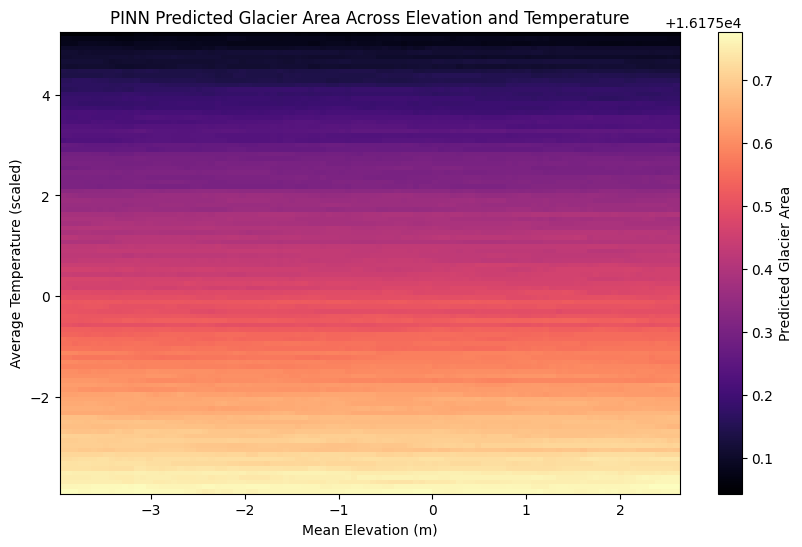

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Assuming `model`, `scaler.mean_`, `scaler.scale_`, `features`, and `features.columns` are defined from the previous context
# and the `model` has been trained with the physics-informed loss function

def generate_meshgrid_data(x_range, y_range, grid_size, feature_indices, mean_features, std_features):
    x = np.linspace(x_range[0], x_range[1], grid_size)
    y = np.linspace(y_range[0], y_range[1], grid_size)
    X, Y = np.meshgrid(x, y)
    grid = np.vstack([X.ravel(), Y.ravel()]).T
    grid_scaled = (grid - mean_features[feature_indices]) / std_features[feature_indices]  # Note the change here
    full_features = np.tile(mean_features, (grid_size**2, 1))
    full_features[:, feature_indices] = grid_scaled
    grid_tensor = torch.tensor(full_features, dtype=torch.float32)
    return X, Y, grid_tensor

def evaluate_model_on_grid(model, grid_tensor):
    model.eval()
    with torch.no_grad():
        predictions = model(grid_tensor).numpy()
    return predictions.reshape(grid_size, grid_size)

# Defining the elevation and temperature indices
elevation_index = features.columns.get_loc('Mean Elevation')
temp_index = features.columns.get_loc('Average_temp')
feature_indices = [elevation_index, temp_index]

# Defining the ranges for the meshgrid based on the normalized features
x_range = [X_train_scaled[:, elevation_index].min(), X_train_scaled[:, elevation_index].max()]
y_range = [X_train_scaled[:, temp_index].min(), X_train_scaled[:, temp_index].max()]
grid_size = 100

# Generate the meshgrid data and evaluate the model
X, Y, grid_tensor = generate_meshgrid_data(x_range, y_range, grid_size, feature_indices, mean_features, std_features)
S = evaluate_model_on_grid(model, grid_tensor)

# Plotting the results
plt.figure(figsize=(10, 6))
contour_plot = plt.pcolormesh(X, Y, S, shading='auto', cmap='magma')
plt.colorbar(contour_plot, label='Predicted Glacier Area')
plt.xlabel('Mean Elevation (m)')
plt.ylabel('Average Temperature (scaled)')
plt.title('PINN Predicted Glacier Area Across Elevation and Temperature')
plt.show()
